## 一、导入数据

In [480]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew

%matplotlib inline

In [481]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [482]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

- 样本容量：1460， 特征数量：81
- 包含大量缺失值的字段：Alley, FireplaceQu, PoolQC, MiscFeature， 都是object类型

## 二、数据预处理

### 2.1 预测变量：SalePrice字段

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1456d5150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x144d34210>]], dtype=object)

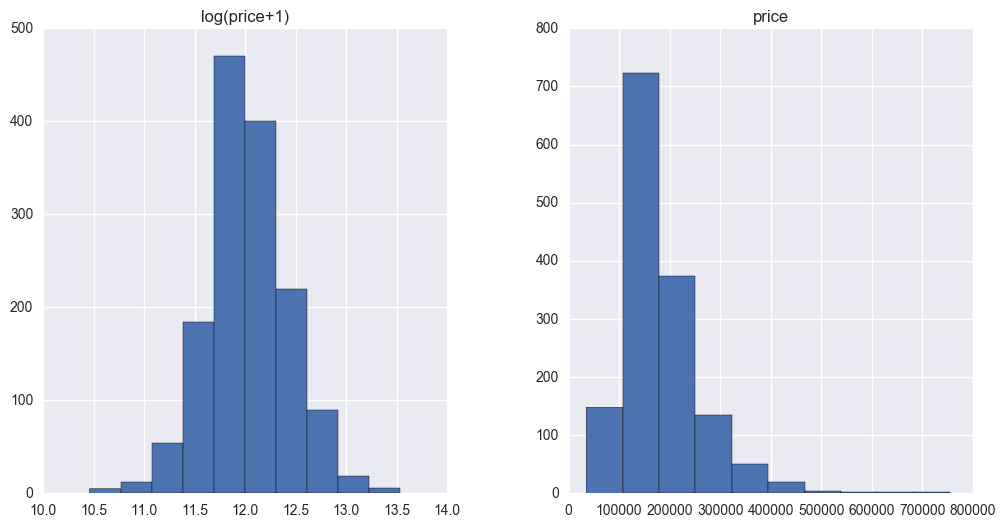

In [483]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({'price': train['SalePrice'], "log(price+1)": np.log1p(train['SalePrice'])})
prices.hist()

In [484]:
# log transform the target:
train['SalePrice'] = np.log1p(train['SalePrice'])

### 2.2 数值型变量

- 后面的模型训练中得出的影响较大的变量：OverallQual, GrLiveArea, 1stFlrSF, TotalBsmtSF

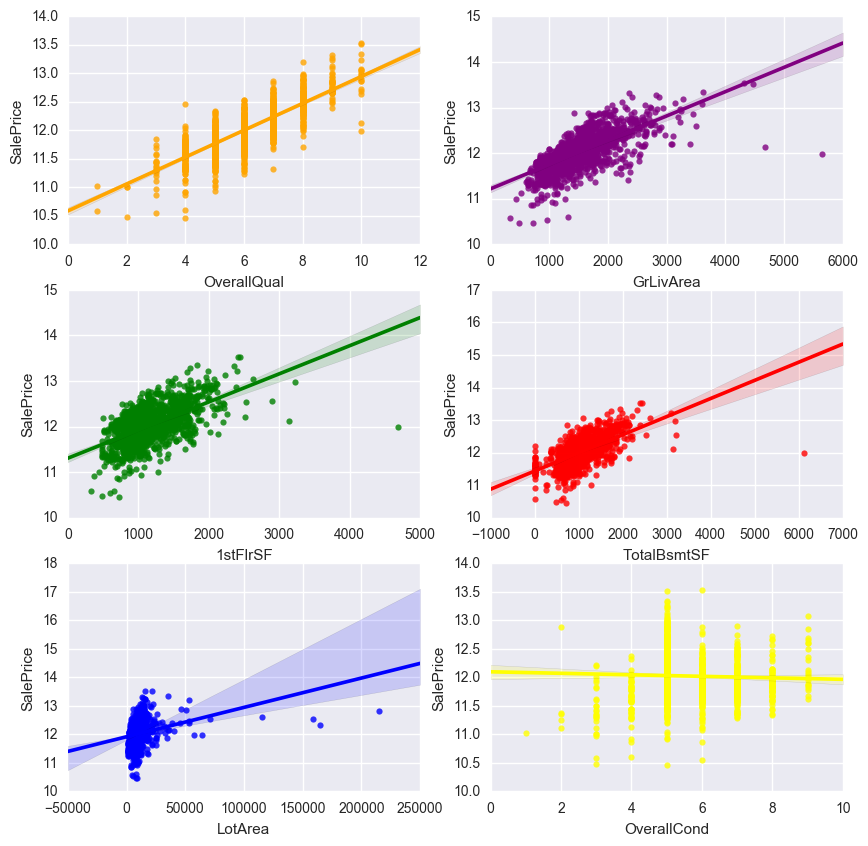

In [485]:
fig, axis = plt.subplots(3, 2, figsize=(10,10))
sns.regplot(x='OverallQual', y='SalePrice', data=train, color='orange', ax=axis[0, 0])
sns.regplot(x='GrLivArea', y='SalePrice', data=train, color='purple', ax=axis[0, 1])
sns.regplot(x='1stFlrSF', y='SalePrice', data=train, color='green', ax=axis[1, 0])
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=train, color='red', ax=axis[1, 1])
sns.regplot(x='LotArea', y='SalePrice', data=train, color='blue', ax=axis[2, 0])
sns.regplot(x='OverallCond', y='SalePrice', data=train, color='yellow', ax=axis[2, 1])

- 在GrLivArea、1stFlrSF和TotalBsmtSF中存在明显的异常点。删除异常点对模型的预测效果是有小幅度提升的。
- OverallQual和OverallCond应该设置为object类型，但是模型预测效果变差了。

In [486]:
# train = train[train.GrLivArea < 4000]
# train = train[train['1stFlrSF'] < 3000]
# train = train[train.TotalBsmtSF < 5000]

### 2.3 类别型变量

- 带有大量缺失值的字段: Alley, PoolQC, MiscFeature, Fence, FireplaceQu。
- 缺失值可能是数据遗漏，或者房子不具有这些特征；后面的假设更贴合实际。
- 查看这些字段不同的值（包括缺失值）对价格的影响

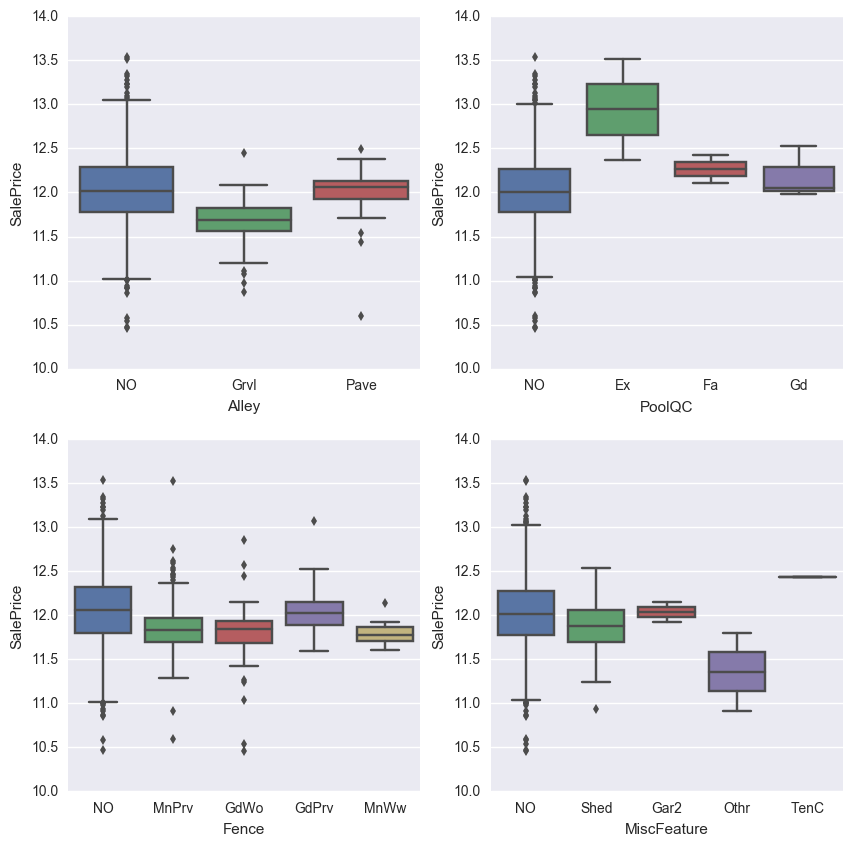

In [487]:
train_tmp = train
fig, axis = plt.subplots(2, 2, figsize=(10,10))
sns.boxplot(x='Alley', y='SalePrice', data=train_tmp.set_value(train_tmp.Alley.isnull(), 'Alley', 'NO'), ax=axis[0, 0])
sns.boxplot(x='PoolQC', y='SalePrice', data=train_tmp.set_value(train_tmp.PoolQC.isnull(), 'PoolQC', 'NO'), ax=axis[0, 1])
sns.boxplot(x='Fence', y='SalePrice', data=train_tmp.set_value(train_tmp.Fence.isnull(), 'Fence', 'NO'), ax=axis[1, 0])
sns.boxplot(x='MiscFeature', y='SalePrice', data=train_tmp.set_value(train_tmp.MiscFeature.isnull(), 'MiscFeature', 'NO'), ax=axis[1, 1])

这些包含大量缺失值的字段先保留

In [488]:
del train_tmp

- Neighborhood

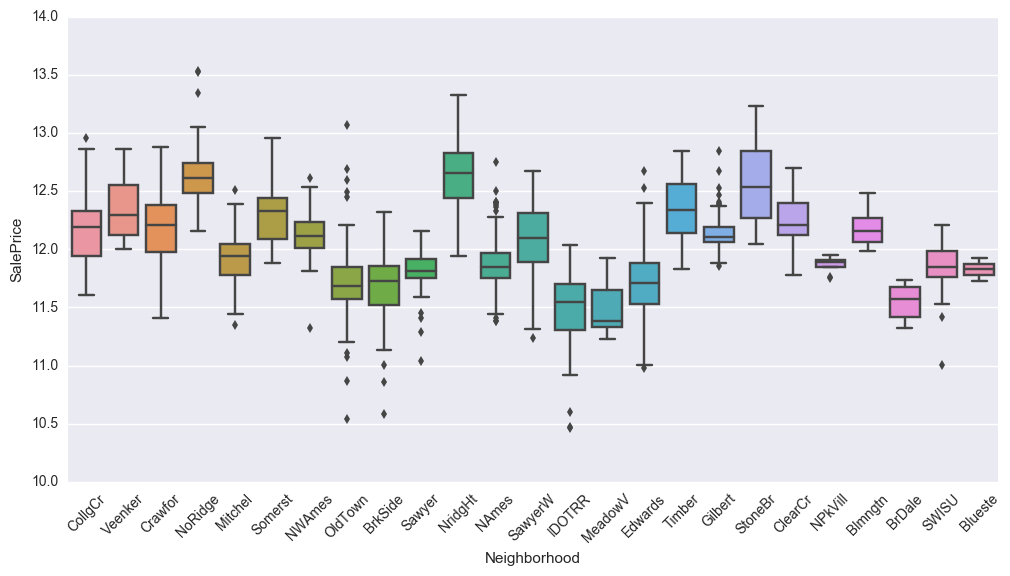

In [489]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train)
xt = plt.xticks(rotation=45)

Neighborhood的差异对SalePrice的影响非常明显。（从后面的模型训练中得出的结论，这里只不过是进行验证）

In [490]:
train = train[train.SalePrice > 10.7]
train = train[train.SalePrice < 13.3]

- RoofMatl

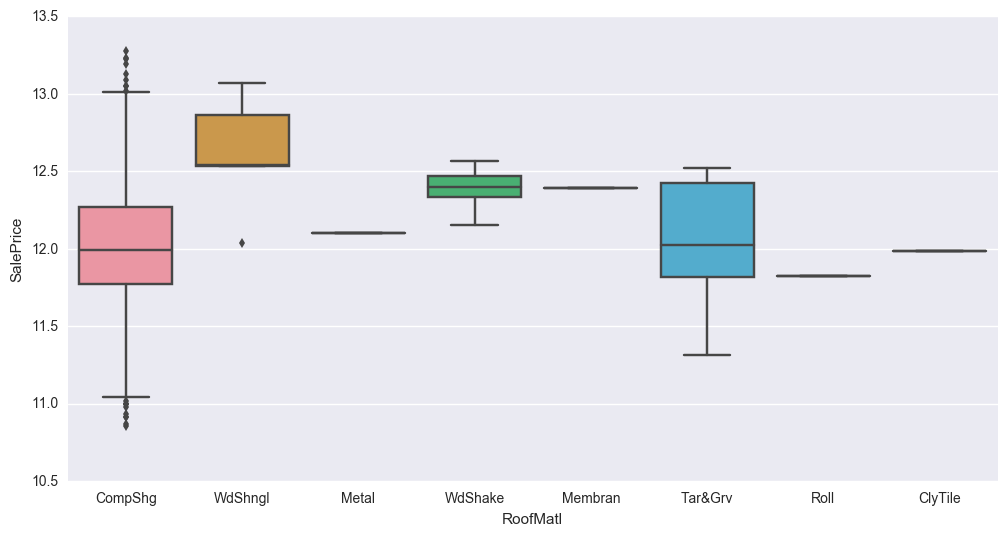

In [491]:
sns.boxplot(x='RoofMatl', y='SalePrice', data=train)

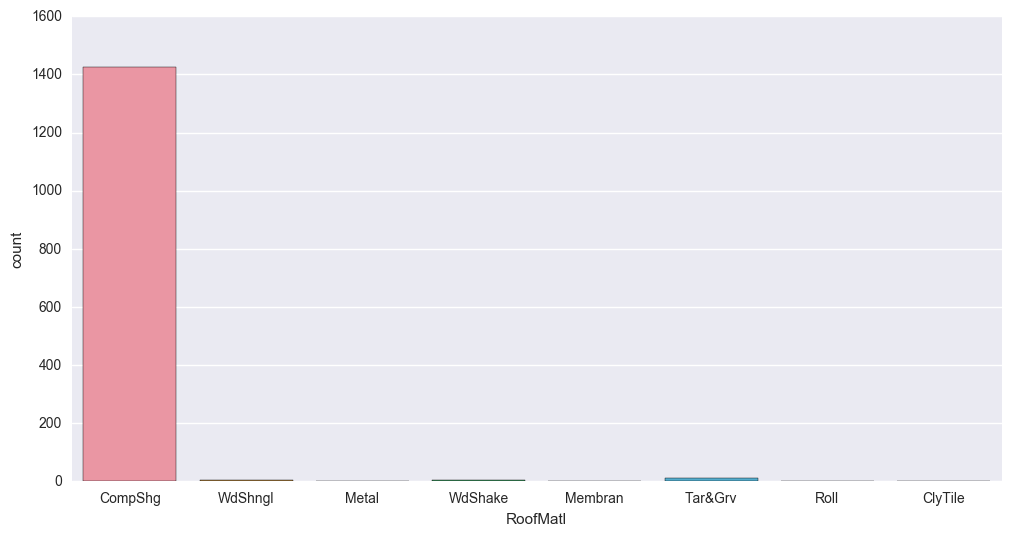

In [492]:
sns.countplot(x='RoofMatl', data=train)

RoofMatl字段分布极不均匀，删除

- MSZoning

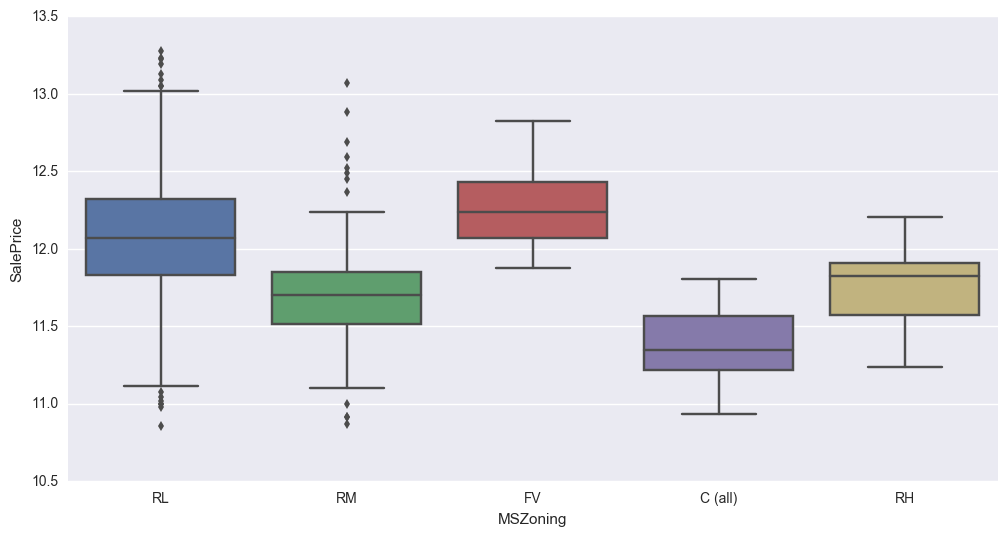

In [493]:
sns.boxplot(x='MSZoning', y='SalePrice', data=train)

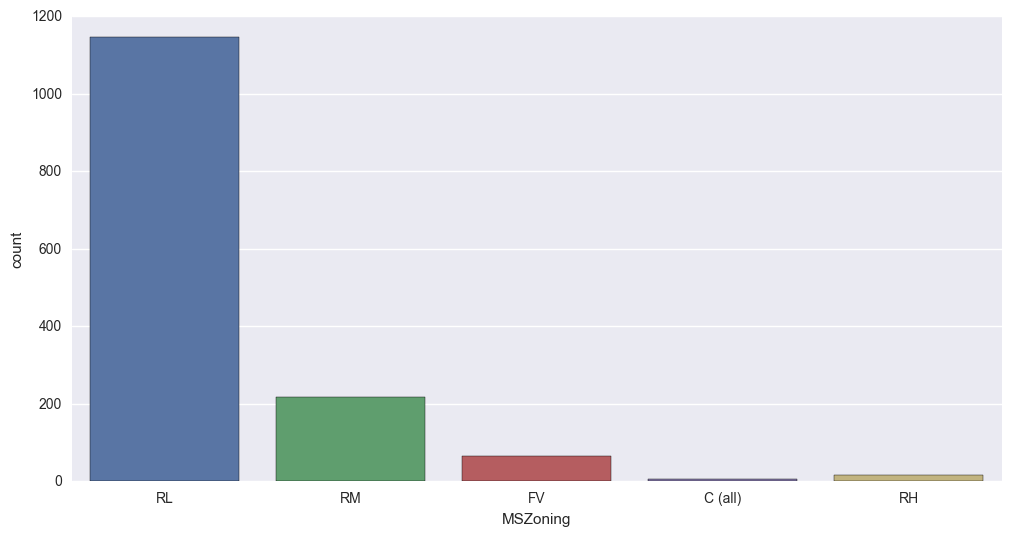

In [494]:
sns.countplot(x='MSZoning', data=train)

保留

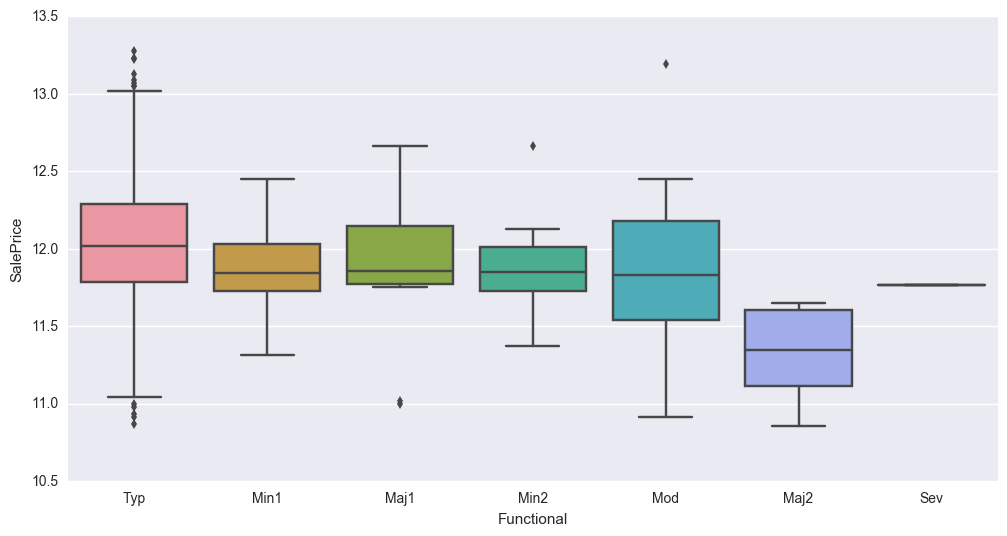

In [495]:
sns.boxplot(x='Functional', y='SalePrice', data=train)

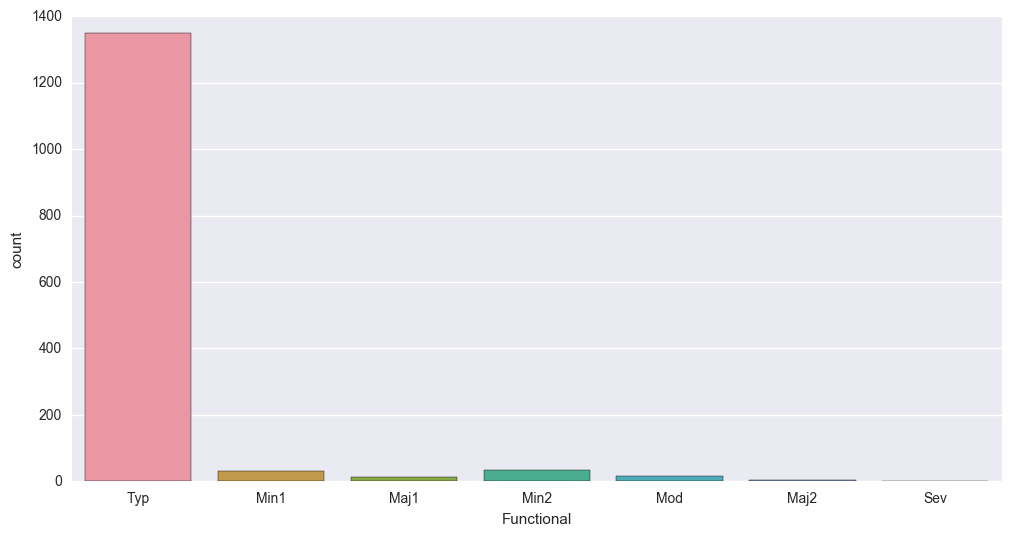

In [496]:
sns.countplot(x='Functional', data=train)

Functional分布不均匀，而且不同的值对SalePrice影响差异不大，可以删除。

### 2.4 train和test合并处理

In [497]:
all_data = pd.concat((train.loc[:, 'MSSubClass': 'SaleCondition'], test.loc[:, 'MSSubClass': 'SaleCondition']))

- 根据上面分析过程，删除分布及其不均匀且对价格影响不大的字段：

In [498]:
all_data.drop(['RoofMatl','Functional'], axis=1, inplace=True)

将OverallQual和OverallCond转换成object类型：

In [499]:
# all_data['OverallQual'] = all_data['OverallQual'].astype('object')
# all_data['OverallCond'] = all_data['OverallCond'].astype('object')

- 连续性变量的偏离度计算与偏离处理

In [500]:
# log transform skewed numeric features:
numeric_feats = all_data.select_dtypes(exclude=['object']).columns
cata_feats = all_data.select_dtypes(include=['object']).columns

print 'Numerical features: ', str(len(numeric_feats))
print 'Categorical features: ', str(len(cata_feats))

skewness = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewness = skewness[abs(skewness) > 0.5]
print str(skewness.shape[0]), ' skewed numerical features to log transform.'

skewed_feats = skewness.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Numerical features:  36
Categorical features:  41
29  skewed numerical features to log transform.


tips: scipy.stats.skew 计算样本的偏离度（skewness, 三阶矩），对于正态分布（Normal distribution），或者高斯分布（Gaussian distribution）偏离度的值大约为0。如果偏离度大于0，说明分布偏向于左边部分；用log处理。

- 类别型变量的dummy处理

In [501]:
all_data = pd.get_dummies(all_data)

tips: get_dummies()是一个很简便的方法用于去除类别型变量中的缺失值。

- 用均值替换NA

In [502]:
# filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

- 数值型变量的scale处理

In [503]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
all_data.loc[:, numeric_feats] = stdsc.fit_transform(all_data.loc[:, numeric_feats])

- 训练集和测试集

In [504]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

- 再将训练集8:2随机分割成训练集和验证集

In [505]:
from sklearn.cross_validation import train_test_split
SEED = 0
X_train_fit, X_train_test, y_train_fit, y_train_test = train_test_split(X_train, y, train_size=0.8, random_state=SEED)

## 三、模型训练与预测

- 采用Lasso（线性L_1正则）和xgboost两个模型进行预测
- 模型预测指标为rmse（root mean square error, 均方根误差）

### 3.1 交叉验证及rmse函数

In [506]:
# from sklearn.linear_model import LassoCV
from sklearn.cross_validation import cross_val_score

from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

from sklearn.cross_validation import cross_val_score
def rmse_cv(model, x, y):  # 5Folds
    return np.sqrt(-cross_val_score(model, x, y, scoring='mean_squared_error', cv=5))

### 3.2 Lasso回归

- 基于交叉验证CV的Lasso模型中的alpha值选择 [使用指南链接](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py)

Computing regularization path using the Lars lasso...


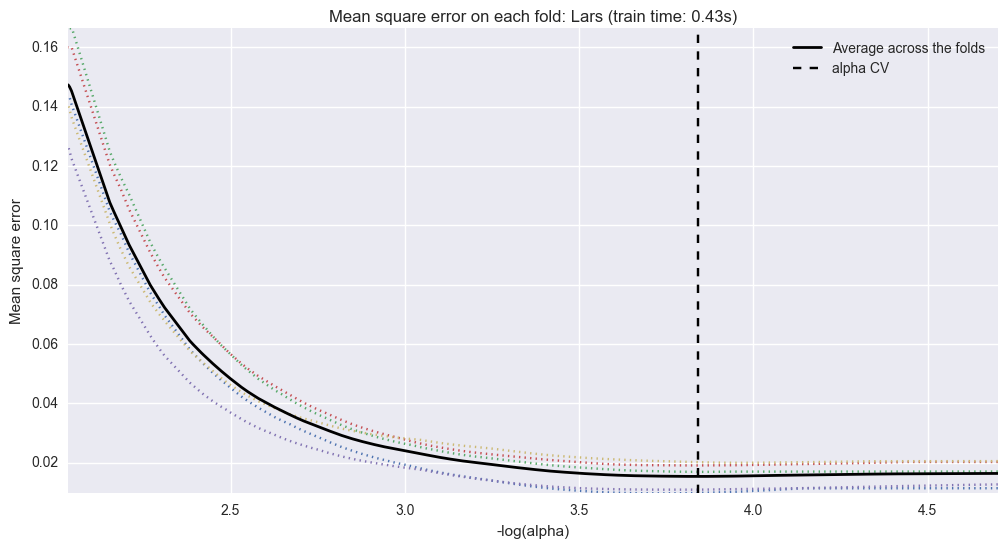

In [507]:
from sklearn.linear_model import LassoLarsCV
import time

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=5).fit(X_train, y)
t_lasso_lars_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.cv_mse_path_, ':')
plt.plot(m_log_alphas, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)' % t_lasso_lars_cv)
plt.axis('tight')
plt.show()

最低的rmse对应的alpha值：10**(-4.0)等于0.00001

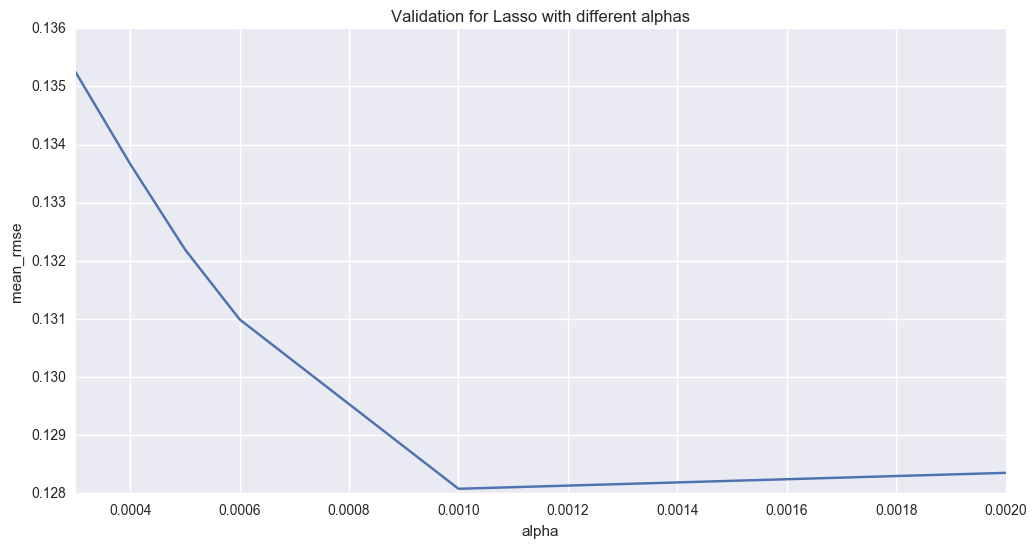

In [508]:
from sklearn.linear_model import Lasso
# select best alpha
alphas = [0.0003, 0.0004, 0.0005, 0.0006, 0.001, 0.002]
cv_alphas = [rmse_cv(Lasso(alpha=alpha, max_iter=5000).fit(X_train_fit, y_train_fit), X_train_fit, y_train_fit).mean() for alpha in alphas]
cv_alphas = pd.Series(cv_alphas, index=alphas)
cv_alphas.plot(title = 'Validation for Lasso with different alphas')
plt.xlabel('alpha')
plt.ylabel('mean_rmse')

- 基于alpha为0.0005，训练Lasso模型

In [509]:
best_alpha = 0.001
model_lasso = Lasso(alpha=best_alpha, max_iter=5000).fit(X_train_fit, y_train_fit)

y_pred_test_lasso = model_lasso.predict(X_train_test)
print 'Lasso rmse on validation set: ', rmse(y_train_test, y_pred_test_lasso)

Lasso rmse on validation set:  0.112252048373


- 残差分布

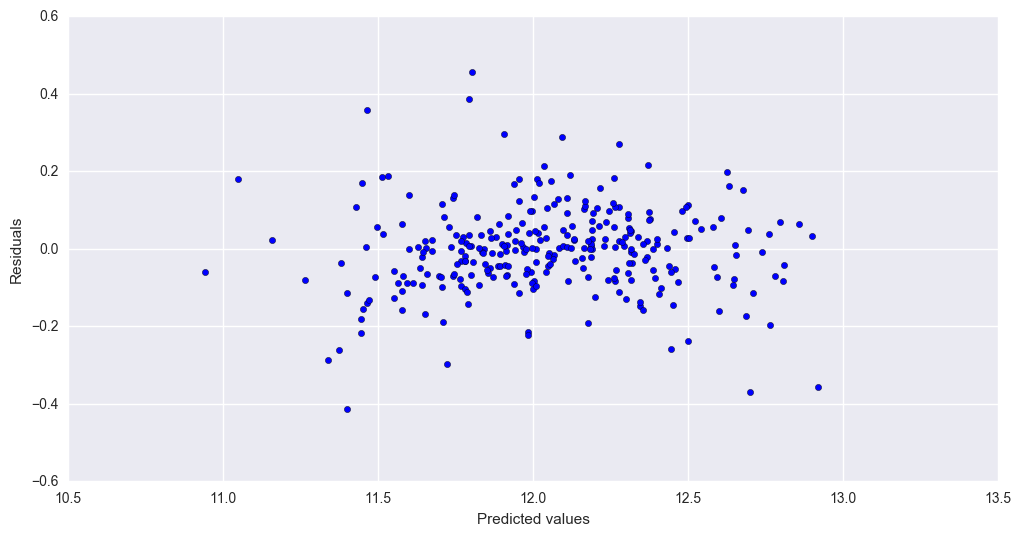

In [510]:
plt.scatter(y_pred_test_lasso, y_pred_test_lasso - y_train_test)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

- Lasso模型的变量系数

In [511]:
coef = pd.Series(model_lasso.coef_, index = X_train_fit.columns)
print 'Lasso picked ', str(sum(coef != 0)), ' variables and eliminated the other ', str(sum(coef == 0)), ' variables.'

Lasso picked  76  variables and eliminated the other  201  variables.


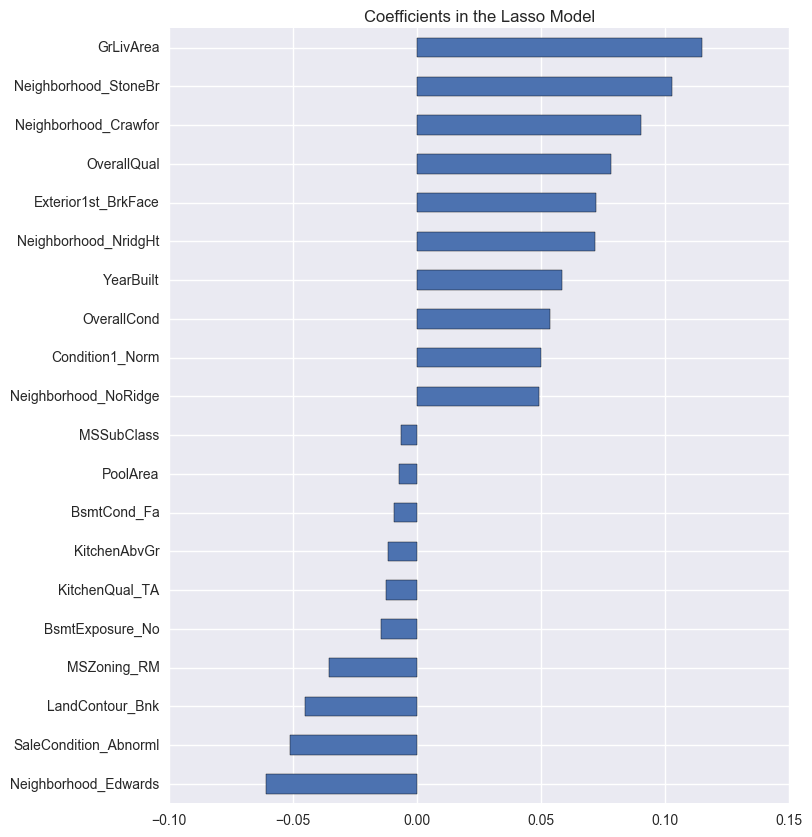

In [512]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = 'barh')
plt.title('Coefficients in the Lasso Model')

- 基于Lasso模型的预测

In [513]:
y_pred_lasso = model_lasso.predict(X_test)
lasso_preds = np.expm1(y_pred_lasso)
predictions_lasso = pd.DataFrame({'id':test.Id, 'SalePrice': lasso_preds})
predictions_lasso.to_csv('solutions_lasso.csv', index = False)

### 3.3 xgboost

- 训练模型

In [396]:
import xgboost as xgb

In [397]:
dtrain = xgb.DMatrix(X_train_fit, label = y_train_fit)
dtest = xgb.DMatrix(X_test)

params = {'max_depth':2, 'eta':0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

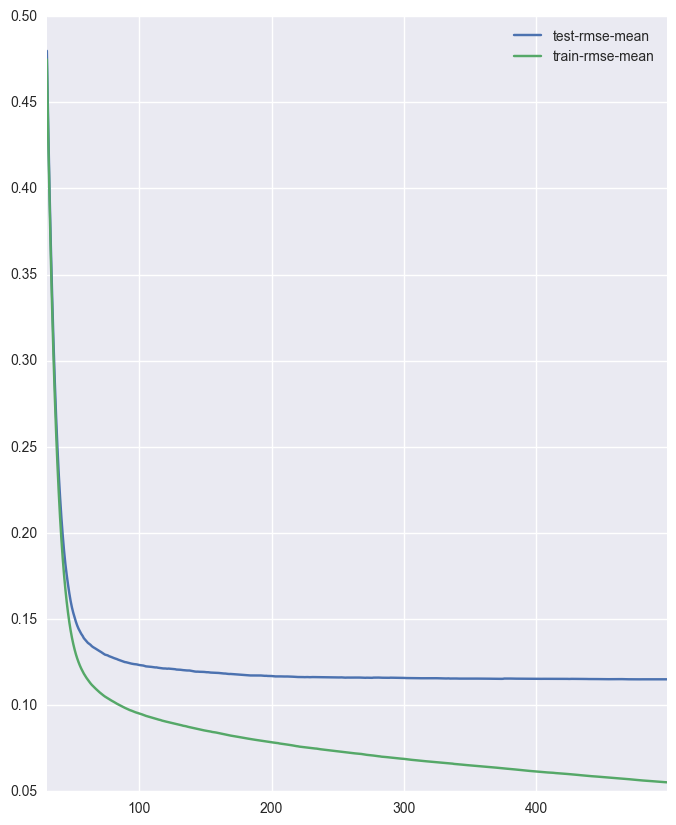

In [398]:
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot()

In [399]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train_fit, y_train_fit)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

- 不同特征的影响大小

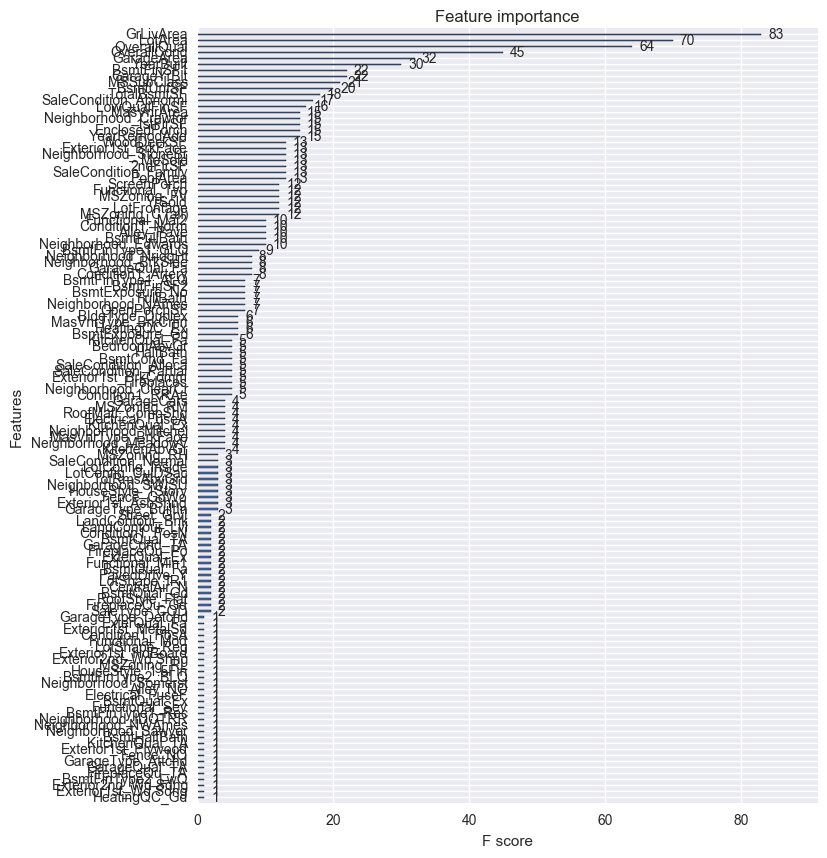

In [400]:
xgb.plot_importance(model_xgb)

In [410]:
y_pred_test_xgb = model_xgb.predict(X_train_test)
print 'xgb rmse socre on validation set: ', rmse(y_train_test, y_pred_test_xgb)

xgb rmse socre on validation set:  0.108253158258


xgboost模型效果在验证集上比Lasso表现要差一点。

- 基于xgboost模型的预测

In [402]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
predictions_xgb = pd.DataFrame({'id':test.Id, 'SalePrice': xgb_preds})
predictions_xgb.to_csv('solutions_xgb.csv', index = False)

### 3.3 Lasso和xgboost

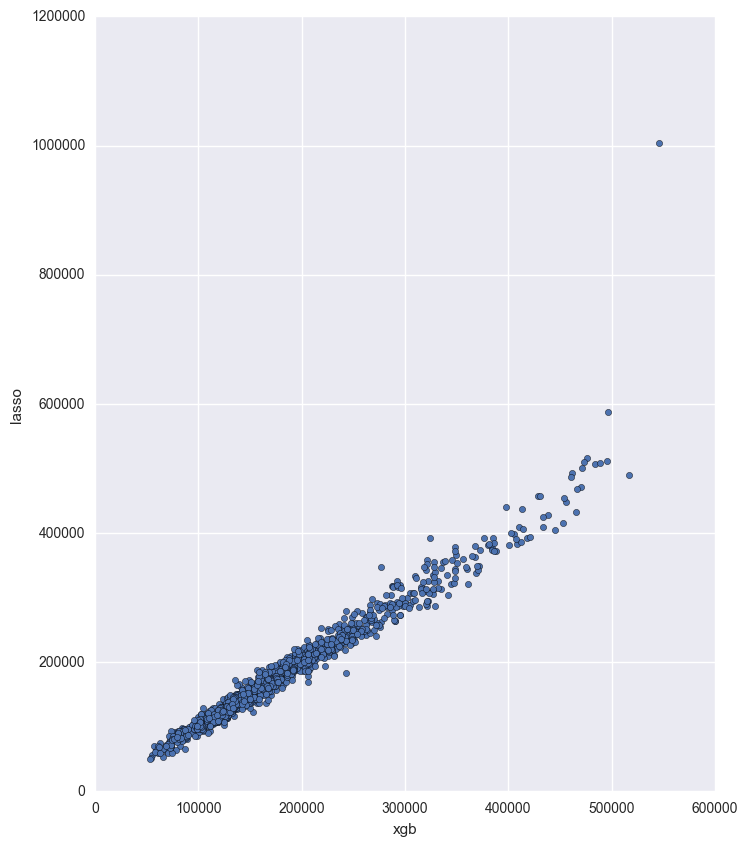

In [403]:
predictions = pd.DataFrame({'xgb': xgb_preds, 'lasso': lasso_preds})
predictions.plot(x='xgb', y='lasso', kind='scatter')

结合Lasso和xgboost的预测值，8:2的分配使得rmse最小

In [404]:
predic_train_merge = np.log1p(0.8*np.expm1(y_pred_test_lasso) + 0.2*np.expm1(y_pred_test_xgb))
print 'Lasso and xgb rmse on training set: ', rmse(y_train_test, predic_train_merge)

Lasso and xgb rmse on training set:  0.100789080893


In [405]:
y_pred = 0.8*lasso_preds + 0.2*xgb_preds
predictions_lassoxgb = pd.DataFrame({'id':test.Id, 'SalePrice': y_pred})
predictions_lassoxgb.to_csv('solutions_merge.csv', index = False)